<a href="https://colab.research.google.com/github/HeqingZ/mvitv2Twarmup5000/blob/main/mvit_v2_T_3x_%E6%94%B9warmup%E4%B9%8B%E5%90%8E%E7%9A%84%E7%AC%AC%E4%B8%80%E9%81%8D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install detectron2
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
#import some important utilities of Detectron2
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
#import features for the bbox
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from detectron2.structures import BoxMode

In [ ]:
#mount on google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#define the file path to retrieve images
def FLIR(source_path, img_dir, anno_dir ): #define a function. assuming user doesnt know shit about coding and enter random stuff. related to anno dir and img dir
    img_dir = os.path.join(source_path, img_dir)
    anno_dir = os.path.join(source_path, anno_dir)
    data_dicts = []
    #define annotation properties
    with open(anno_dir) as F:
      jsonfile = json.load(F) #load annotations from json file into the dictionary
    
    annotationinfo = jsonfile["annotations"]
    imagesinfo = jsonfile["images"] #retreieve info like category ID and bbox
   
    #define img sources
     
    img_dir_list = os.listdir(img_dir)#get the list of all files and directories in the specified directory.
    # print(img_dir)
    for img_info in imagesinfo: #bbox info category id
      for images in img_dir_list:  #img_dir_list = img_dir, which is source_path/img_dir(original)
        images = "data/" + images
        if images == img_info['file_name']: #see if name matches each other, because we wanna find the filenames only for the small flir out of the whole json file

          record={}
          filename = os.path.join(source_path, img_info["file_name"])
          # print(filename)
          record["file_name"] = filename
          record["image_id"] = img_info['id']
          record["height"] = img_info['height']
          record['width'] = img_info['width']
        
          box_info = []
          
          for anno in annotationinfo:
            if anno["image_id"] == img_info['id']:
              # if (anno['category_id'] <= 3) & (anno['category_id'] > 0):
              if (anno['category_id'] == 1) & (anno['category_id'] > 0): # Predict people only
                        box = {
                        "bbox": anno['bbox'],
                        'bbox_mode': BoxMode.XYWH_ABS, # Category_id starts from 0 in detectron2
                        'category_id': int(anno['category_id']-1)  #we forcibly convert this shit into integer to be able to minus 1. just incase the stuff from the dict is integer
                        #computer counts from zero but not hyman. we have to substract one to match the computer #update Jun29: i deleted -1, bcz there is no category 0 
                        } #exactly how dictionary looks like
                        imagetesthaha = cv2.imread(filename, 0) 
                        tt = cv2.rectangle(imagetesthaha, anno["bbox"], (255,0,0),2)
                        #cv2_imshow(tt) #for printing all boxes in images one by one, will crash
                        box_info.append(box)
          record["annotations"] = box_info

          data_dicts.append(record)
    return data_dicts

      
      
    #print(type(jsonfile)) #check the  type of jsonfile. dict or list or stuff



#define dataloader for training and testing sets
#train_dataloader = dataloader(training_data, batch_size=64, shuffle=True)
#test_dataloader = dataloader(test_data, batch_size=64, shuffle=True)


In [ ]:
DatasetCatalog.clear() #unregister stuff

In [ ]:
for d in ["train", "val"]:
    DatasetCatalog.register("FLIR_THERMAL_" + d + "_data", lambda d=d: FLIR("/content/drive/MyDrive/FLIR_THERMAL/train", "data", "coco.json")) #changed "/directry/stuff/" +d +"shit" into this rn
    MetadataCatalog.get("FLIR_THERMAL_" + d + "_data").set(thing_classes=["FLIR_THERMAL"])
FLIR_metadata = MetadataCatalog.get("FLIR_THERMAL_train_data")


In [ ]:
#to varify our thing by calling the function
dataset_dicts = FLIR("/content/drive/MyDrive/FLIR_THERMAL/train", "data", "coco.json")


In [ ]:
!nvidia-smi

Sun Aug 14 23:35:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
#refrence only 
#how to train a network from scratch
''' 
 
!python tools/main.py \
  --cfg configs/MViTv2_T.yaml \
  DATA.PATH_TO_DATA_DIR path_to_your_dataset \
  NUM_GPUS 8 \
  TRAIN.BATCH_SIZE 256 \
''' 

' \n \n!python tools/main.py   --cfg configs/MViTv2_T.yaml   DATA.PATH_TO_DATA_DIR path_to_your_dataset   NUM_GPUS 8   TRAIN.BATCH_SIZE 256 '

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("Misc/mask_rcnn_R_50_FPN_1x_dconv_c3-c5.yaml"))
!python tools/main.py --cfg configs/MViTv2_T.yaml DATA.PATH_TO_DATA_DIR "/content/drive/MyDrive/FLIR_THERMAL/train" --num-gpus 8

#!tools/dist_train.sh configs/swin/mask_rcnn_swin_tiny_patch4_window7_mstrain_480-800_adamw_1x_coco.py 8 --cfg-options model.pretrained=<PRETRAIN_MODEL> 


cfg.DATASETS.TRAIN = ("FLIR_THERMAL_train_data",)
cfg.MODEL.RESNETS.DEPTH = 50 #for mvit v2 S we are setting the depth = 101. (F)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 5  # This is the real "batch size" commonly known to deep learning people 'changed to 5'
cfg.SOLVER.BASE_LR = 0.0001 #SET ALL TO 0.0001
cfg.SOLVER.MAX_ITER = 270000    # 270000 for 3x (F)
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 5000
cfg.SOLVER.WARMUP_ITERS = 5000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # chose 512 for 3x
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (people). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.MODEL.MASK_ON = False
# cfg.MODEL.RESNETS.DEFORM_MODULATED = True
cfg.MODEL.BACKBONE.FREEZE_AT = 0
cfg.OUTPUT_DIR = '/content/drive/MyDrive/mvitv2T3x_5000warmup'


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

python3: can't open file 'tools/main.py': [Errno 2] No such file or directory
[08/19 19:14:30 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1),

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[08/19 19:26:46 d2.utils.events]:  eta: 3 days, 1:12:14  iter: 19  total_loss: 25.92  loss_cls: 7.309  loss_box_reg: 1.901  loss_rpn_cls: 10.41  loss_rpn_loc: 8.928  time: 0.9174  data_time: 0.0682  lr: 3.9992e-07  max_mem: 11369M
[08/19 19:27:13 d2.utils.events]:  eta: 4 days, 3:34:41  iter: 39  total_loss: 18.65  loss_cls: 14.04  loss_box_reg: 0.6769  loss_rpn_cls: 1.187  loss_rpn_loc: 2.891  time: 1.1579  data_time: 0.0554  lr: 7.9984e-07  max_mem: 11640M
[08/19 19:27:40 d2.utils.events]:  eta: 4 days, 3:26:27  iter: 59  total_loss: 14.61  loss_cls: 10.52  loss_box_reg: 0.2856  loss_rpn_cls: 0.7735  loss_rpn_loc: 1.497  time: 1.2158  data_time: 0.0587  lr: 1.1998e-06  max_mem: 11640M
[08/19 19:28:06 d2.utils.events]:  eta: 4 days, 3:36:59  iter: 79  total_loss: 3.99  loss_cls: 2.291  loss_box_reg: 0.1114  loss_rpn_cls: 0.4102  loss_rpn_loc: 0.7596  time: 1.2459  data_time: 0.0532  lr: 1.5997e-06  max_mem: 11640M
[08/19 19:28:33 d2.utils.events]:  eta: 4 days, 3:49:20  iter: 99  tota

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
from detectron2.utils.visualizer import ColorMode

#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # ALL THRESHOLD = 0.5
#Pass the validation dataset
cfg.DATASETS.TEST = ("boardetect_val", )

predictor = DefaultPredictor(cfg)

[08/18 03:43:26 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                         | Shapes                                          |
|:------------------------------------------------|:--------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.res2.0.conv1.*                         | backbone.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}     | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.res2.0.conv2.*                         | backbone.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}     | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.res2.0.conv3.*                         | backbone.res2.0.conv3.{norm.bias,norm.running_mean,norm.running_var,norm.weig

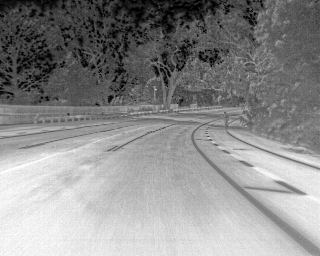

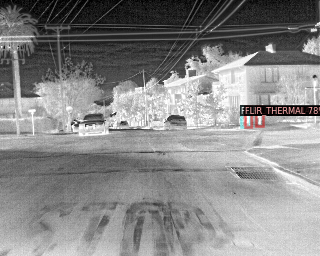

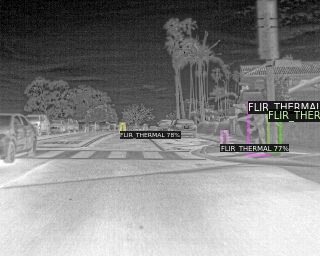

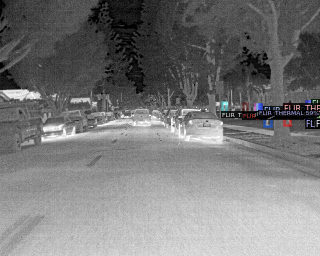

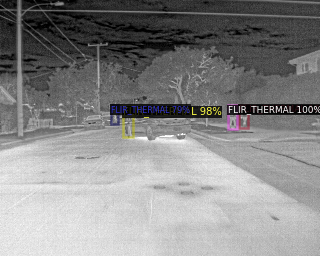

In [ ]:
#see if this shit is wroking aka run instance on test images
from detectron2.utils.visualizer import ColorMode
dataset_dicts = FLIR("/content/drive/MyDrive/FLIR_THERMAL/val/", "data", "coco.json")
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=FLIR_metadata, 
                   scale=0.5, 
                      # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 #ALL THRESHOLD = 0.5 
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("FLIR_THERMAL_train_data", cfg, False, output_dir="content/output/")
val_loader = build_detection_test_loader(cfg, "FLIR_THERMAL_val_data")
inference_on_dataset(trainer.model, val_loader, evaluator)

[08/18 05:35:42 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                         | Shapes                                          |
|:------------------------------------------------|:--------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.res2.0.conv1.*                         | backbone.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}     | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.res2.0.conv2.*                         | backbone.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}     | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.res2.0.conv3.*                         | backbone.res2.0.conv3.{norm.bias,norm.running_mean,norm.running_var,norm.weig

OrderedDict([('bbox',
              {'AP': 28.883363564430496,
               'AP50': 61.94006942243908,
               'AP75': 23.58084145309815,
               'APs': 22.54796460917092,
               'APm': 51.49452925515456,
               'APl': 50.11169758458698})])